# Cuaderno 03: Procesamiento por Lotes y Análisis Estadístico

**Objetivo:** Este cuaderno automatiza la ejecución de los pipelines de segmentación (Cuaderno 01) y análisis morfológico (Cuaderno 02) para un conjunto completo de imágenes. Una vez procesadas todas las imágenes, consolida los datos y realiza un análisis estadístico para comparar las métricas de los astrocitos entre los grupos experimentales (Control vs. Hipoxia).

**Flujo de Trabajo:**
1.  **Configuración e Importaciones**: Cargar librerías y definir los parámetros principales.
2.  **Refactorización a Funciones**: Convertir la lógica de los cuadernos 1 y 2 en funciones reutilizables para el procesamiento de una sola imagen.
3.  **Descubrimiento de Archivos**: Localizar automáticamente todas las imágenes `.tif` a procesar en las carpetas `CTL` y `hip`.
4.  **Ejecución del Pipeline por Lotes**: Iterar sobre cada imagen, ejecutar las funciones de segmentación y análisis, y guardar los resultados individuales.
5.  **Consolidación de Datos**: Combinar los resultados de todas las imágenes en una única tabla (DataFrame) maestra.
6.  **Análisis Estadístico**: Comparar las métricas morfológicas entre los grupos Control e Hipoxia utilizando pruebas estadísticas apropiadas.
7.  **Visualización de Resultados**: Generar gráficos (boxplots) para visualizar las diferencias entre los grupos y la significancia estadística.

In [1]:
# ## Paso 1.1: Instalar Librerías Adicionales
# Instalamos las librerías necesarias para la estadística y la visualización.
%pip install pingouin seaborn --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
# ## Paso 1.2: Importaciones Principales
import pandas as pd
import numpy as np
from pathlib import Path
import tifffile
import napari
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt

# Importaciones de los pipelines anteriores
from aicsimageio import AICSImage
from cellpose import models
from skimage.measure import regionprops, label
from skimage.morphology import skeletonize, remove_small_objects
from skimage.filters import threshold_otsu
from scipy.ndimage import binary_dilation
from scipy.spatial import ConvexHull
import skan



Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.6 
platform:       	linux 
python version: 	3.12.3 
torch version:  	2.8.0+cu128! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




## Paso 2: Refactorización de los Pipelines a Funciones

Para procesar múltiples imágenes de manera eficiente, convertimos la lógica de los cuadernos anteriores en dos funciones principales: `pipeline_segmentacion` y `pipeline_morfologia`. Esto nos permite llamar a todo el flujo de trabajo con una sola línea de código por imagen, haciendo el proceso limpio y modular.

In [7]:
# ## Paso 2.1: Función del Pipeline de Segmentación (Cuaderno 01)

def pipeline_segmentacion(image_path, output_dir, params):
    """
    Ejecuta el pipeline de segmentación completo para una sola imagen.
    Devuelve la ruta a la máscara final de astrocitos.
    """
    print(f"--- Iniciando Segmentación para: {image_path.name} ---")
    
    # 1. Carga y Calibración Automática
    img = AICSImage(image_path)
    image_stack = img.get_image_data("ZCXY", T=0)
    dapi_channel = image_stack[:, 0, :, :]
    gfap_channel = image_stack[:, 1, :, :]
    microglia_channel = image_stack[:, 2, :, :]

    Z_SPACING_UM = img.physical_pixel_sizes.Z
    PIXEL_HEIGHT_UM = img.physical_pixel_sizes.Y
    PIXEL_WIDTH_UM = img.physical_pixel_sizes.X
    
    # LÍNEA CORREGIDA: Definimos la variable PHYSICAL_SCALE dentro de la función
    PHYSICAL_SCALE = (Z_SPACING_UM, PIXEL_HEIGHT_UM, PIXEL_WIDTH_UM)
    
    VOXEL_VOLUME_UM3 = PIXEL_WIDTH_UM * PIXEL_HEIGHT_UM * Z_SPACING_UM
    MIN_VOLUME_VOXELS = int(params['MIN_VOLUME_UM3'] / VOXEL_VOLUME_UM3)

    # 2. Otsu
    otsu_threshold = threshold_otsu(dapi_channel)
    dapi_channel_cleaned = np.where(dapi_channel > otsu_threshold, dapi_channel, 0)

    # 3. Cellpose
    model = models.CellposeModel(gpu=True)
    cellpose_masks, _, _ = model.eval(dapi_channel_cleaned, diameter=params['NUCLEUS_DIAMETER'], z_axis=0, do_3D=True)

    # 4. Filtrado Combinado (GFAP / Microglía)
    astrocyte_labels_candidate = []
    nuclei_props = regionprops(cellpose_masks)
    for nucleus in nuclei_props:
        nucleus_mask = (cellpose_masks == nucleus.label)
        current_mask = nucleus_mask
        for i in range(params['MAX_DILATION_ITERATIONS']):
            dilated_mask = binary_dilation(current_mask)
            shell_mask = dilated_mask & ~current_mask
            if not np.any(shell_mask): break
            if microglia_channel[shell_mask].mean() > params['MICROGLIA_INTENSITY_THRESHOLD']: break
            if gfap_channel[shell_mask].mean() > params['GFAP_INTENSITY_THRESHOLD']:
                astrocyte_labels_candidate.append(nucleus.label)
                break
            current_mask = dilated_mask
    
    gfap_filtered_mask = np.where(np.isin(cellpose_masks, astrocyte_labels_candidate), cellpose_masks, 0)

    # 5. Filtro de Tamaño
    final_props = regionprops(gfap_filtered_mask)
    final_astrocyte_labels = [prop.label for prop in final_props if prop.area >= MIN_VOLUME_VOXELS]
    final_mask = np.where(np.isin(gfap_filtered_mask, final_astrocyte_labels), gfap_filtered_mask, 0)
    
    # Guardado y retorno
    final_mask_path = output_dir / f"{image_path.stem}_final_mask.tif"
    tifffile.imwrite(final_mask_path, final_mask.astype(np.uint16))
    print(f"Segmentación completada. {len(final_astrocyte_labels)} astrocitos encontrados.")
    
    # Ahora la variable PHYSICAL_SCALE existe y puede ser devuelta
    return final_mask_path, image_stack, PHYSICAL_SCALE

In [8]:
# ## Paso 2.2: Función del Pipeline de Morfología (Cuaderno 02)

def pipeline_morfologia(final_mask_path, image_stack, physical_scale, params):
    """
    Ejecuta el pipeline de análisis morfológico para una máscara segmentada.
    Devuelve un DataFrame de pandas con los resultados.
    """
    print(f"--- Iniciando Morfología para: {final_mask_path.name} ---")
    
    # 1. Carga de datos y calibración
    astrocyte_mask = tifffile.imread(final_mask_path)
    gfap_channel = image_stack[:, 1, :, :]
    
    Z_SPACING_UM, PIXEL_HEIGHT_UM, PIXEL_WIDTH_UM = physical_scale
    VOXEL_VOLUME_UM3 = PIXEL_WIDTH_UM * PIXEL_HEIGHT_UM * Z_SPACING_UM
    
    # 2. Bucle de Análisis por Astrocito
    all_morphology_results = []
    astrocyte_ids = np.unique(astrocyte_mask)[1:]
    
    if not astrocyte_ids.any():
        print("No se encontraron astrocitos en la máscara para analizar.")
        return pd.DataFrame() # Devuelve un DataFrame vacío si no hay células

    binarized_gfap = gfap_channel > threshold_otsu(gfap_channel)

    for astro_id in astrocyte_ids:
        single_astrocyte_mask_bool = (astrocyte_mask == astro_id)
        props = regionprops(single_astrocyte_mask_bool.astype(np.uint8))[0]
        
        nucleus_volume_voxels = props.area
        centroid_z, centroid_y, centroid_x = props.centroid
        
        astrocyte_processes = binarized_gfap & single_astrocyte_mask_bool
        
        total_length_um = 0
        num_branches = 0
        if np.any(astrocyte_processes):
            skeleton = remove_small_objects(skeletonize(astrocyte_processes), min_size=2, connectivity=1)
            if np.any(skeleton):
                branch_data = skan.summarize(skan.Skeleton(skeleton.astype(np.uint8), spacing=physical_scale), separator='-')
                total_length_um = branch_data['branch-distance'].sum()
                num_branches = len(branch_data)

        gfap_volume_voxels = np.sum(astrocyte_processes)
        mean_gfap_intensity = np.mean(gfap_channel[astrocyte_processes]) if gfap_volume_voxels > 0 else 0

        points = np.argwhere(single_astrocyte_mask_bool)
        territory_volume_um3 = ConvexHull(points * np.array(physical_scale)).volume if len(points) > 3 else 0
        
        all_morphology_results.append({
            'label': astro_id,
            'nucleus_volume_um3': nucleus_volume_voxels * VOXEL_VOLUME_UM3,
            'gfap_volume_um3': gfap_volume_voxels * VOXEL_VOLUME_UM3,
            'mean_gfap_intensity': mean_gfap_intensity,
            'total_process_length_um': total_length_um,
            'num_branches': num_branches,
            'territory_volume_um3': territory_volume_um3,
        })
    
    print("Análisis morfológico completado.")
    return pd.DataFrame(all_morphology_results)

## Paso 3 y 4: Descubrimiento de Archivos y Ejecución por Lotes

Ahora definimos los parámetros de análisis, buscamos todos los archivos `.tif` en las subcarpetas de `data/raw`, e iteramos sobre ellos, aplicando las dos funciones que acabamos de crear. Los resultados de cada imagen (cada DataFrame) se almacenan en una lista para su posterior consolidación.

In [9]:
# ## Paso 3 y 4: Ejecución

# Parámetros centralizados para los pipelines
ANALYSIS_PARAMS = {
    "NUCLEUS_DIAMETER": 30,
    "MAX_DILATION_ITERATIONS": 40,
    "GFAP_INTENSITY_THRESHOLD": 10,
    "MICROGLIA_INTENSITY_THRESHOLD": 10,
    "MIN_VOLUME_UM3": 75,
}

# Rutas principales
project_root = Path.cwd().parent
raw_data_dir = project_root / "data/raw"
processed_data_dir = project_root / "data/processed"
processed_data_dir.mkdir(exist_ok=True)

# 1. Descubrimiento de archivos
image_files = sorted(list(raw_data_dir.rglob("*.tif")))
print(f"Se encontraron {len(image_files)} imágenes para procesar.")

# 2. Bucle de procesamiento
all_results_list = []
for f_path in image_files:
    # Extraer información del nombre y la carpeta
    group = f_path.parent.parent.name # 'CTL' o 'hip'
    image_id = f_path.stem

    # Crear un directorio de salida único para esta imagen
    output_dir = processed_data_dir / image_id
    output_dir.mkdir(exist_ok=True)
    
    # Ejecutar Pipeline 1: Segmentación
    final_mask_path, image_stack, physical_scale = pipeline_segmentacion(f_path, output_dir, ANALYSIS_PARAMS)
    
    # Ejecutar Pipeline 2: Morfología
    morphology_df = pipeline_morfologia(final_mask_path, image_stack, physical_scale, ANALYSIS_PARAMS)
    
    # Añadir información de la imagen al DataFrame
    if not morphology_df.empty:
        morphology_df['group'] = group
        morphology_df['image_id'] = image_id
        all_results_list.append(morphology_df)

print("\n--- PROCESAMIENTO POR LOTES COMPLETADO ---")

Se encontraron 24 imágenes para procesar.
--- Iniciando Segmentación para: Inmuno 26-07-23.lif - CTL 1-2 a.tif ---
Segmentación completada. 15 astrocitos encontrados.
--- Iniciando Morfología para: Inmuno 26-07-23.lif - CTL 1-2 a_final_mask.tif ---
Análisis morfológico completado.
--- Iniciando Segmentación para: Inmuno 26-07-23.lif - CTL 1-2 b.tif ---
Segmentación completada. 0 astrocitos encontrados.
--- Iniciando Morfología para: Inmuno 26-07-23.lif - CTL 1-2 b_final_mask.tif ---
No se encontraron astrocitos en la máscara para analizar.
--- Iniciando Segmentación para: Inmuno 26-07-23.lif - CTL 1-2 c.tif ---
Segmentación completada. 1 astrocitos encontrados.
--- Iniciando Morfología para: Inmuno 26-07-23.lif - CTL 1-2 c_final_mask.tif ---
Análisis morfológico completado.
--- Iniciando Segmentación para: Inmuno 26-07-23.lif - CTL 1-2 d.tif ---
Segmentación completada. 53 astrocitos encontrados.
--- Iniciando Morfología para: Inmuno 26-07-23.lif - CTL 1-2 d_final_mask.tif ---
Análisis

## Paso 5: Consolidación de Datos

Combinamos los resultados de todas las imágenes, que están en `all_results_list`, en un único DataFrame maestro. Este DataFrame será la base para todo el análisis estadístico.

In [10]:
if all_results_list:
    master_df = pd.concat(all_results_list, ignore_index=True)

    # Guardamos la tabla maestra
    results_dir = project_root / "results/tables"
    results_dir.mkdir(exist_ok=True)
    master_df.to_csv(results_dir / "master_morphology_results.csv", index=False)

    print("Tabla maestra consolidada y guardada.")
    print(f"Total de astrocitos analizados: {len(master_df)}")
    display(master_df.head())
    display(master_df.groupby(['group', 'image_id']).size().reset_index(name='astrocytes_count'))
else:
    print("No se generaron resultados para consolidar.")

Tabla maestra consolidada y guardada.
Total de astrocitos analizados: 661


,label,nucleus_volume_um3,gfap_volume_um3,mean_gfap_intensity,total_process_length_um,num_branches,territory_volume_um3,group,image_id
0,11,209.086068,0.000000,0.0,0.0,0,205.281001,CTL,Inmuno 26-07-23.lif - CTL 1-2 a
1,24,259.804251,0.144496,93.0,0.0,0,293.568207,CTL,Inmuno 26-07-23.lif - CTL 1-2 a
2,27,295.205831,0.000000,0.0,0.0,0,267.173559,CTL,Inmuno 26-07-23.lif - CTL 1-2 a
3,57,178.452864,0.000000,0.0,0.0,0,159.764683,CTL,Inmuno 26-07-23.lif - CTL 1-2 a
4,149,169.783089,0.144496,86.0,0.0,0,155.887367,CTL,Inmuno 26-07-23.lif - CTL 1-2 a


,group,image_id,astrocytes_count
0,CTL,Inmuno 26-07-23.lif - CTL 1-2 a,15
1,CTL,Inmuno 26-07-23.lif - CTL 1-2 c,1
2,CTL,Inmuno 26-07-23.lif - CTL 1-2 d,53
3,CTL,Inmuno 26-07-23.lif - CTL 10-8 b,43
4,CTL,Inmuno 26-07-23.lif - CTL 10-8 c,71
5,CTL,Inmuno 26-07-23.lif - CTL 25-1 a,1
6,CTL,Inmuno 26-07-23.lif - CTL 27-4 a,80
7,CTL,Inmuno 26-07-23.lif - CTL 27-4 b,77
8,CTL,Inmuno 26-07-23.lif - CTL 27-4 c,70
9,CTL,Inmuno 26-07-23.lif - cTL 10-8 a,78


## Paso 6: Análisis Estadístico

Con la tabla maestra lista, podemos comparar directamente las métricas entre los grupos. Usaremos la prueba **U de Mann-Whitney**, que es una prueba no paramétrica robusta, ideal para comparar dos grupos independientes sin asumir que los datos siguen una distribución normal.

Iteraremos sobre cada una de las métricas morfológicas y realizaremos la prueba entre los grupos 'CTL' y 'hip'.

In [11]:
if 'master_df' in locals():
    # Métricas que queremos comparar
    metrics_to_compare = [
        'gfap_volume_um3',
        'mean_gfap_intensity',
        'total_process_length_um',
        'num_branches',
        'territory_volume_um3'
    ]

    # Realizar la prueba estadística para cada métrica
    statistical_results = []
    for metric in metrics_to_compare:
        ctl_data = master_df[master_df['group'] == 'CTL'][metric].dropna()
        hip_data = master_df[master_df['group'] == 'hip'][metric].dropna()
        
        # Realizamos el test U de Mann-Whitney
        stats = pg.mwu(ctl_data, hip_data, alternative='two-sided')
        stats['metric'] = metric
        statistical_results.append(stats)

    # Consolidamos los resultados estadísticos en una tabla
    stats_df = pd.concat(statistical_results).set_index('metric')
    print("Resultados del Análisis Estadístico (U de Mann-Whitney):")
    display(stats_df[['U-val', 'p-val', 'CLES']])
else:
    print("La tabla maestra no está disponible para el análisis estadístico.")

Resultados del Análisis Estadístico (U de Mann-Whitney):


,U-val,p-val,CLES
metric,,,
gfap_volume_um3,48242.0,3.626576e-03,0.573572
mean_gfap_intensity,59164.5,8.815580e-16,0.703435
total_process_length_um,47938.5,3.914957e-03,0.569964
num_branches,48365.0,1.908798e-03,0.575034
territory_volume_um3,34928.5,9.406108e-04,0.415282


## Paso 7: Visualización de Resultados

Finalmente, visualizamos los resultados. Un **boxplot** es una excelente manera de mostrar la distribución de los datos para cada grupo, la mediana y los cuartiles. Añadiremos los puntos de datos individuales para ver la dispersión completa. El título de cada gráfico incluirá el valor *p* de la prueba estadística para interpretar fácilmente la significancia del resultado.

/tmp/ipykernel_1555532/918993912.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=master_df, x='group', y=metric, ax=ax, palette=['royalblue', 'orangered'], width=0.5)
/tmp/ipykernel_1555532/918993912.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=master_df, x='group', y=metric, ax=ax, palette=['royalblue', 'orangered'], width=0.5)
/tmp/ipykernel_1555532/918993912.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=master_df, x='group', y=metric, ax=ax, palette=['royalblue', 'orangered'], width=0.5)
/tmp/ipykernel_1

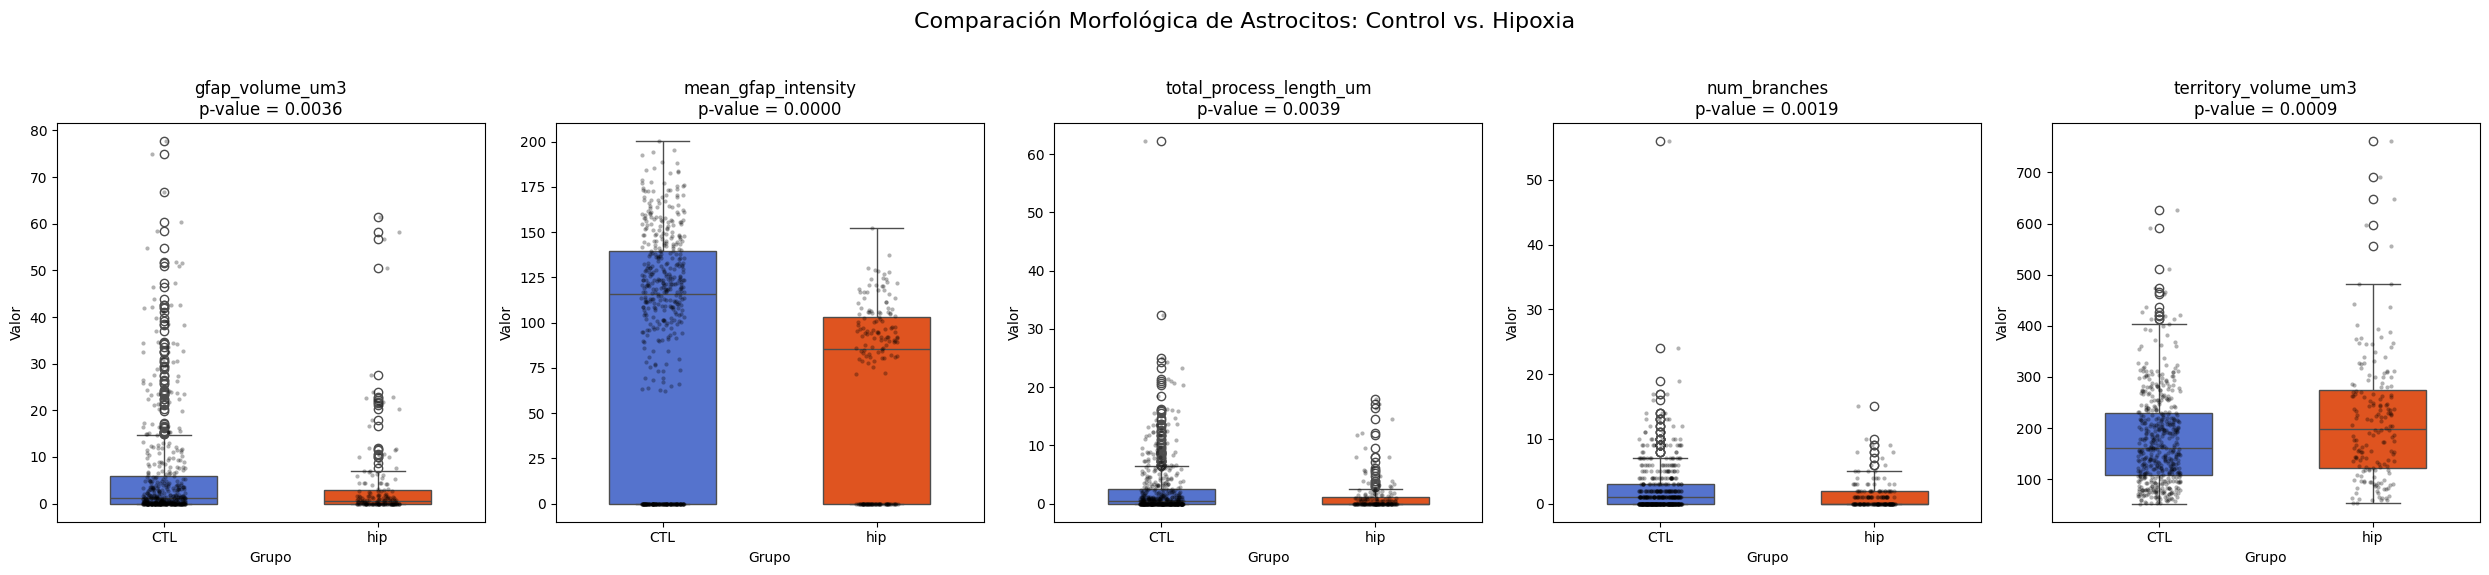

In [12]:
if 'stats_df' in locals():
    # Creamos una figura con subplots para cada métrica
    n_metrics = len(metrics_to_compare)
    fig, axes = plt.subplots(1, n_metrics, figsize=(n_metrics * 5, 6))
    fig.suptitle('Comparación Morfológica de Astrocitos: Control vs. Hipoxia', fontsize=16)

    for i, metric in enumerate(metrics_to_compare):
        ax = axes[i]
        
        # Boxplot con Seaborn
        sns.boxplot(data=master_df, x='group', y=metric, ax=ax, palette=['royalblue', 'orangered'], width=0.5)
        # Superponer los puntos individuales
        sns.stripplot(data=master_df, x='group', y=metric, ax=ax, color='black', alpha=0.3, size=3)
        
        # Añadir el valor p al título
        p_value = stats_df.loc[metric, 'p-val']
        ax.set_title(f'{metric}\np-value = {p_value:.4f}')
        ax.set_xlabel('Grupo')
        ax.set_ylabel('Valor')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("No hay datos para visualizar.")